In [1]:
### Please ignore the warning messages due to duplicate methods
library(readxl)
library(dplyr)
library(lubridate)
library(ggplot2)
library(tseries)
library(forecast)
library(TTR)
library(zoo)
library(xts)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last



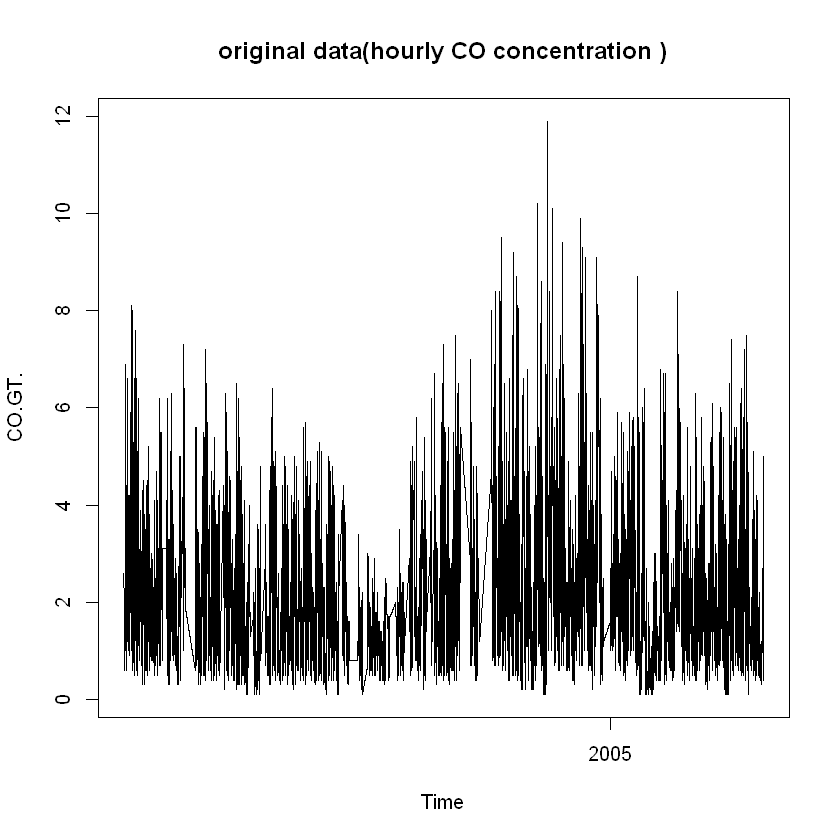

In [2]:
### Read the excel file
airquality<-read_excel("C:\\Users\\poonam\\Downloads\\AirQualityUCI\\AirQualityUCI.xlsx")
#airquality
### add the data to dataframe for manipulation
a<-data.frame(airquality)
#a
### Selecled the few columns(date, time and co) from the data frame 
df_co<-select(a,Date,Time,CO.GT.)
#df_co
testdata <- df_co
### manipulation of time columns( chose hour)
testdata1 <- mutate(testdata, Time = hour(testdata$Time))
testdata2 <- mutate(testdata1, date2 = update(testdata1$Date,hour = testdata1$Time))
#testdata2
cleanedset1 <- select(testdata2, date2, CO.GT.)
cleanedset1$CO.GT.[cleanedset1$CO.GT. == -200] <- NA
z <- zoo(select(cleanedset1,CO.GT.))
x <- na.fill(z, "extend")
b <- data.frame(x)
colnames(b) <- c("hourly averaged concentration CO")
cleanset2=cbind(cleanedset1,b)
cleanset3 = select(cleanset2,date2,'hourly averaged concentration CO')
x3.index <- select(cleanset3,date2)
x3.data <- select(cleanset3,'hourly averaged concentration CO')
x4 <-zoo(x3.data,x3.index$date2)
plot(x4,main="original data(hourly CO concentration )",xlab="Time",ylab="CO.GT.")

In [3]:
############# 1 day data
ep_1day <- endpoints(x4,'days',1)
result_1day <- period.apply(x4,INDEX = ep_1day,FUN = mean)
df_result_1day <- as.data.frame(result_1day)
head(df_result_1day)

,result_1day
2004-03-10 23:00:00,1.966667
2004-03-11 23:00:00,2.172917
2004-03-12 23:00:00,2.756250
2004-03-13 23:00:00,2.639583
2004-03-14 23:00:00,2.441667
2004-03-15 23:00:00,3.402083


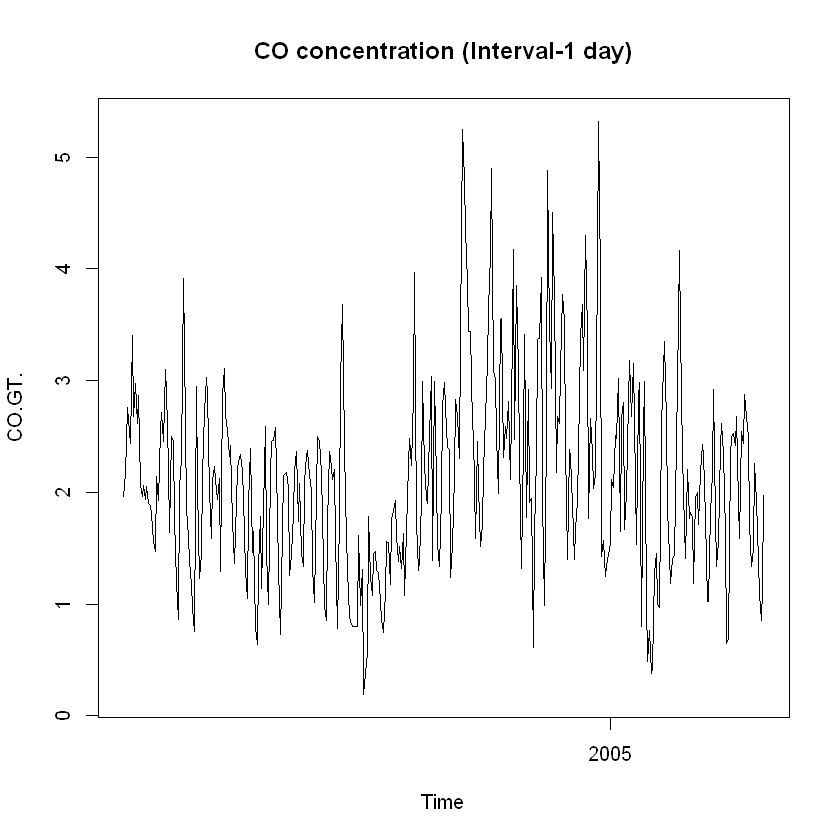

In [4]:
plot(result_1day,main="CO concentration (Interval-1 day)",xlab="Time",ylab="CO.GT.")

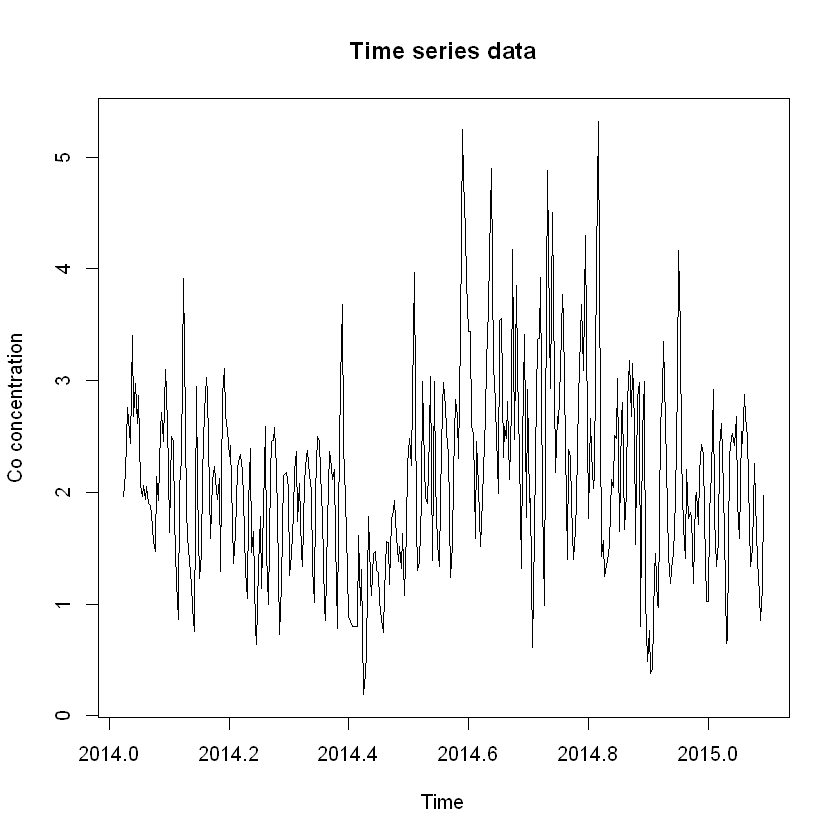

In [5]:
############convert the data to Time series
colnames(df_result_1day)<-c("co")
series<-ts(result_1day,frequency=365,start=c(2014,10))
#str(series)
### Plot the time series data
plot(series,main="Time series data",ylab="Co concentration")

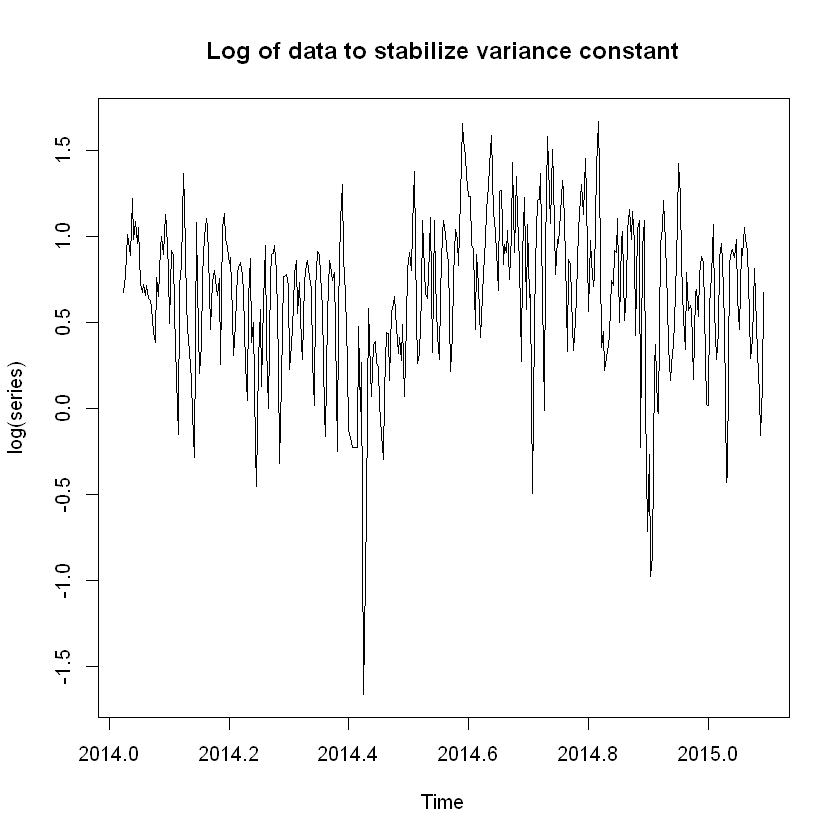

In [6]:
### Make the data stationary(log of data to stabilize non-constant variance)
plot(log(series),main="Log of data to stabilize variance constant")

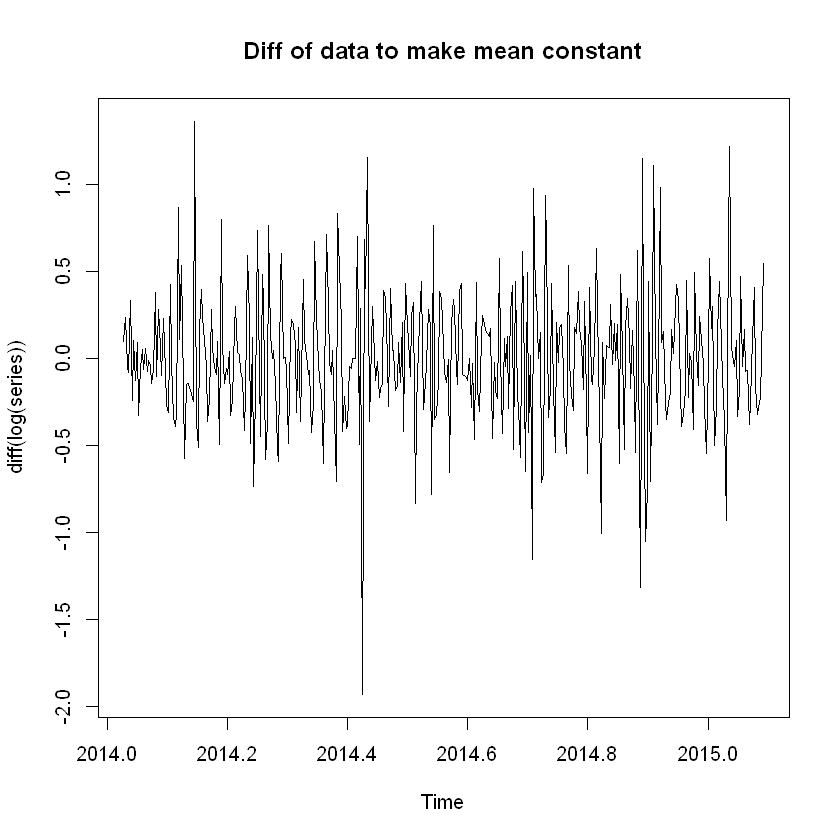

In [7]:
### Make the mean constant
plot(diff(log(series)),main="Diff of data to make mean constant")

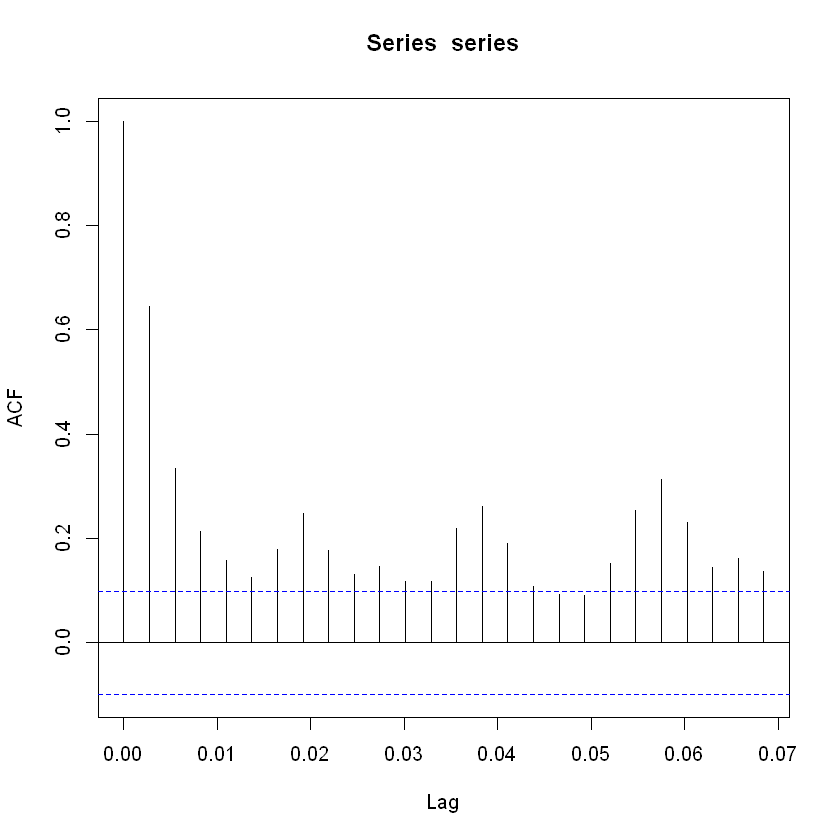

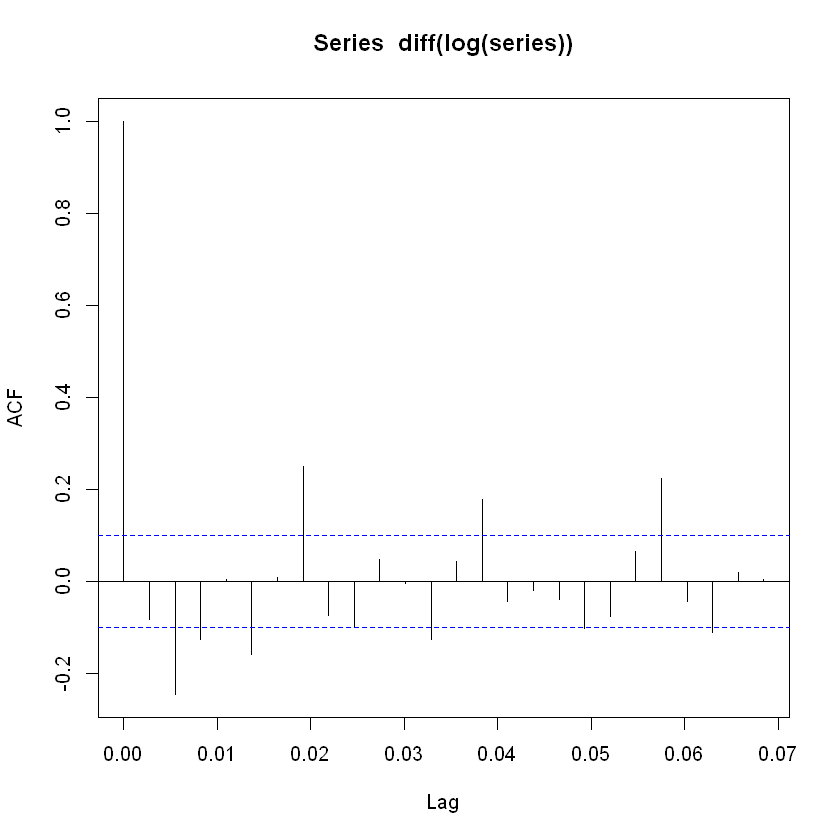

Warning message:
"The chosen seasonal unit root test encountered an error when testing for the first difference.
From stl(): series is not periodic or has less than two periods
0 seasonal differences will be used. Consider using a different unit root test."

Series: series 
ARIMA(0,1,3) 

Coefficients:
          ma1      ma2      ma3
      -0.2732  -0.4322  -0.1862
s.e.   0.0496   0.0474   0.0503

sigma^2 estimated as 0.4278:  log likelihood=-387.02
AIC=782.05   AICc=782.15   BIC=797.91

Warning message:
"The chosen seasonal unit root test encountered an error when testing for the first difference.
From stl(): series is not periodic or has less than two periods
0 seasonal differences will be used. Consider using a different unit root test."


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2)             with drift         : 788.9916
 ARIMA(0,1,0)             with drift         : 872.1428
 ARIMA(1,1,0)             with drift         : 873.5326
 ARIMA(0,1,1)             with drift         : 870.5227
 ARIMA(0,1,0)                                : 870.1428
 ARIMA(1,1,2)             with drift         : 783.8637
 ARIMA(0,1,2)             with drift         : 795.4394
 ARIMA(1,1,1)             with drift         : 797.9905
 ARIMA(1,1,3)             with drift         : 785.655
 ARIMA(0,1,3)             with drift         : 783.7789
 ARIMA(0,1,4)             with drift         : 785.4827
 ARIMA(1,1,4)             with drift         : 787.6292
 ARIMA(0,1,3)                                : 781.8198
 ARIMA(0,1,2)                                : 793.4893
 ARIMA(1,1,3)                                : 783.7507
 ARIMA(0,1,4)                                : 783.5219
 ARIMA(1,1,2)                               

Series: series 
ARIMA(0,1,3) 

Coefficients:
          ma1      ma2      ma3
      -0.2732  -0.4322  -0.1862
s.e.   0.0496   0.0474   0.0503

sigma^2 estimated as 0.4278:  log likelihood=-387.02
AIC=782.05   AICc=782.15   BIC=797.91

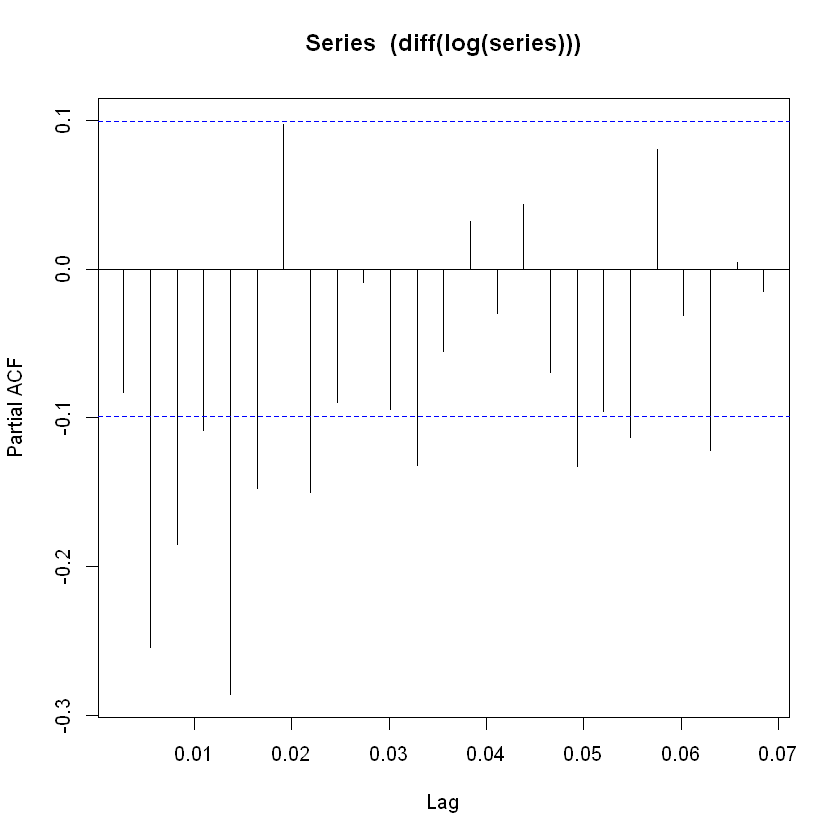

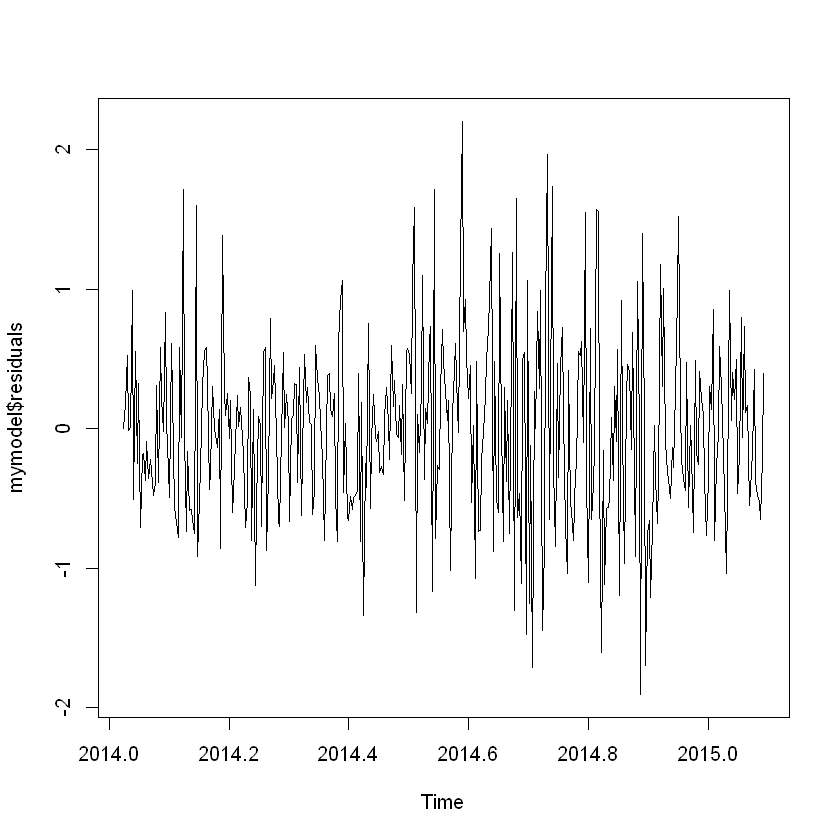

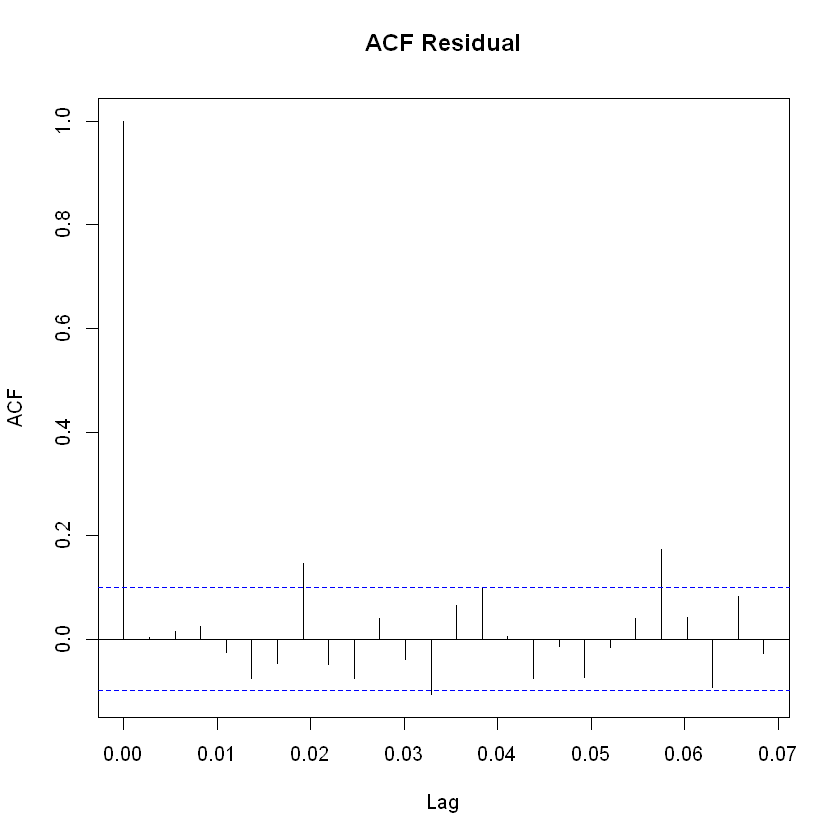

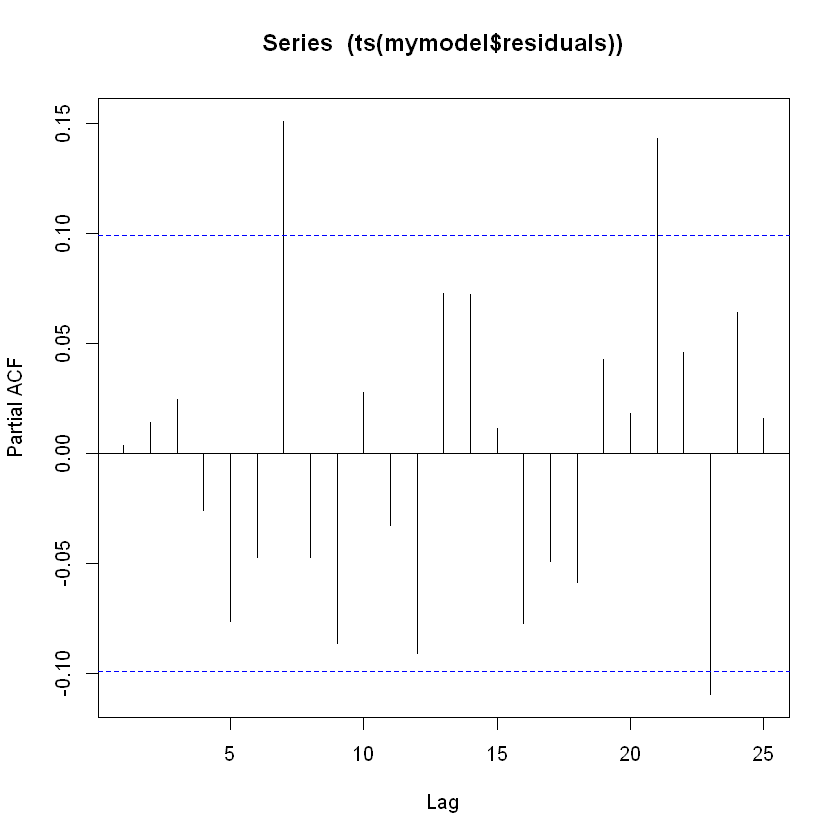

In [8]:
###  ARIMA Model
### Auto correlation factor on non stationary data
acf(series)
### Auto correlation factor on stationary data
acf(diff(log(series)))
### Partial auto correlation factor on stationary data
pacf((diff(log(series))))
### ARIMA model
mymodel<-auto.arima(series)
mymodel

### to see possible combination of p,d,q
auto.arima(series,ic="aic",trace=TRUE)

### plot the model
plot.ts(mymodel$residuals)
acf((mymodel$residuals),main='ACF Residual')
pacf((ts(mymodel$residuals)))

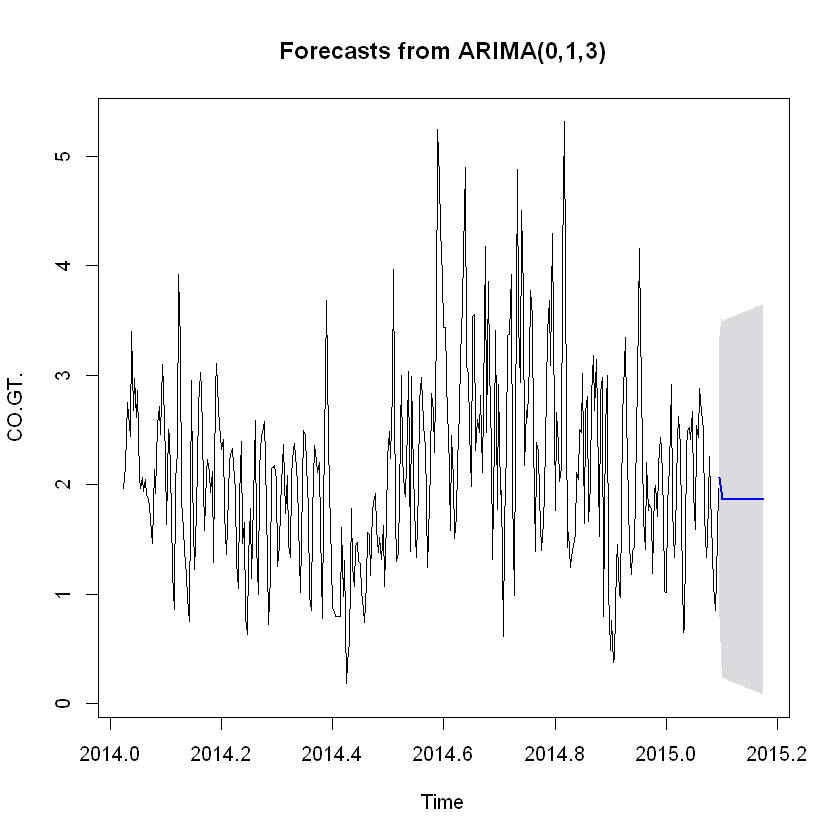

In [9]:
############# forcast the model 
myforecast<-forecast(mymodel,level=c(95),h=30)
plot(myforecast,xlab="Time",ylab="CO.GT.")

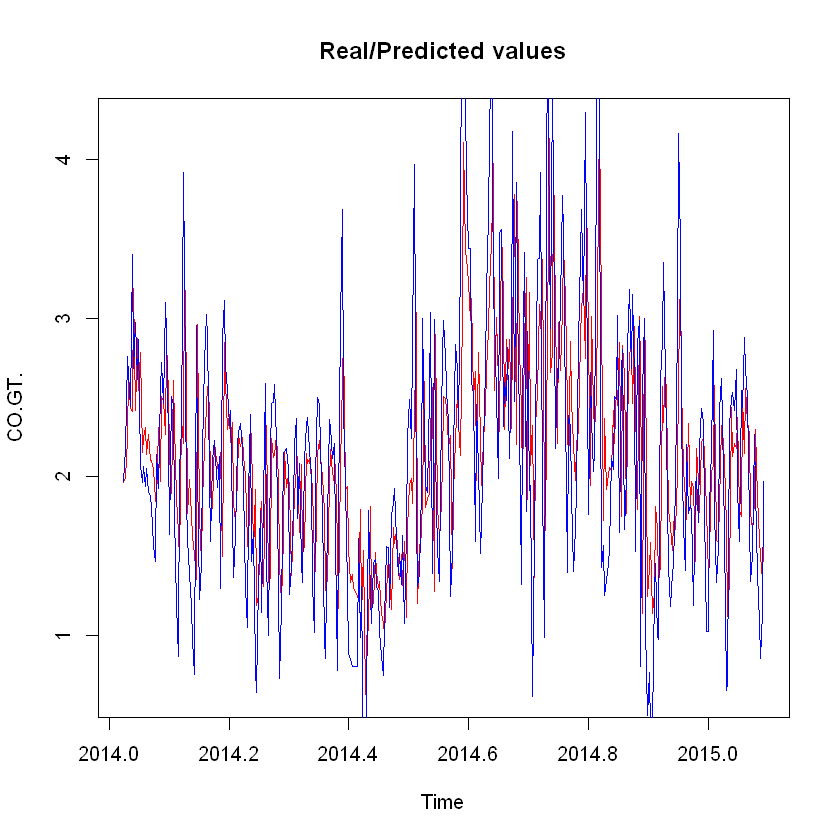

In [10]:
### line plot of real values and predicted values
predict_val=fitted(myforecast)
original_val=series
plot(predict_val,col="red",main="Real/Predicted values",ylab="CO.GT.")
lines(series,col="blue")

In [11]:
############ Accuracy measures of model
accuracy(myforecast)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.01076306,0.6506968,0.5062511,-13.59133,31.07386,0.680791,0.00356592


In [12]:
################ Correlation between real values and predicted values
res<-cor.test(predict_val,original_val,method="pearson")
res


	Pearson's product-moment correlation

data:  predict_val and original_val
t = 17.695, df = 389, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6089522 0.7193316
sample estimates:
     cor 
0.667797 
